# strategy - Q18 Machine Learning Rolling Basis MODFIED S&P ShortLong Returns


In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
! pip install git+https://github.com/quantiacs/toolbox.git 2>/dev/null


  Cloning https://github.com/quantiacs/toolbox.git to /tmp/pip-req-build-5qa4myh3
  Resolved https://github.com/quantiacs/toolbox.git to commit 9639920fc7916c3eb69fe94776702a6d937b6b04
  Preparing metadata (setup.py) ... done


In [3]:
import os
os.environ['API_KEY'] = "8bd4083d-ad62-40b0-a60b-a05c54f71825"
os.environ['NONINTERACT'] = 'True'

import logging

import xarray as xr  # xarray for data manipulation

import qnt.data as qndata     # functions for loading data
import qnt.backtester as qnbt # built-in backtester
import qnt.ta as qnta         # technical analysis library
import qnt.stats as qnstats   # statistical functions
import qnt.output as qnout

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

np.seterr(divide = "ignore")

from qnt.ta.macd import macd
from qnt.ta.rsi  import rsi
from qnt.ta.stochastic import stochastic_k, stochastic, slow_stochastic

from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

NOTICE: The environment variable DATA_BASE_URL was not specified. The default value is 'https://data-api.quantiacs.io/'
NOTICE: The environment variable CACHE_RETENTION was not specified. The default value is '7'
NOTICE: The environment variable CACHE_DIR was not specified. The default value is 'data-cache'


In [4]:
# loading s&p-500 stock data for training
# Selección de 5 activos de diferentes sectores para diversificación:
# Tecnología: AAPL (Apple), MSFT (Microsoft)
# Consumo: AMZN (Amazon)
# Finanzas: JPM (JPMorgan Chase)
# Salud: JNJ (Johnson & Johnson)
assets = ["NAS:AAPL", "NAS:MSFT", "NAS:AMZN", "NYS:JPM", "NYS:JNJ"]
data = qndata.stocks.load_spx_data(min_date  ='2019-01-01', max_date ='2023-12-31', assets = assets)

fetched chunk 1/1 1s
Data loaded 2s


In [5]:
[asset for asset in qndata.stocks_load_spx_list() if 'NAS:'+asset['symbol'] in assets]

[{'name': 'Apple Inc',
  'sector': 'IT/Telecommunications',
  'symbol': 'AAPL',
  'exchange': 'NAS',
  'id': 'NAS:AAPL',
  'cik': '320193',
  'FIGI': 'tts-831814'},
 {'name': 'Amazon.com Inc',
  'sector': 'IT/Telecommunications',
  'symbol': 'AMZN',
  'exchange': 'NAS',
  'id': 'NAS:AMZN',
  'cik': '1018724',
  'FIGI': 'tts-827705'},
 {'name': 'Microsoft Corporation',
  'sector': 'IT/Telecommunications',
  'symbol': 'MSFT',
  'exchange': 'NAS',
  'id': 'NAS:MSFT',
  'cik': '789019',
  'FIGI': 'tts-829802'}]

In [6]:
[asset for asset in qndata.stocks_load_spx_list() if 'NYS:'+asset['symbol'] in assets]

[{'name': 'Johnson and Johnson',
  'sector': 'Healthcare',
  'symbol': 'JNJ',
  'exchange': 'NYS',
  'id': 'NYS:JNJ',
  'cik': '200406',
  'FIGI': 'tts-825807'},
 {'name': 'JP Morgan Chase and Co',
  'sector': 'Finance',
  'symbol': 'JPM',
  'exchange': 'NYS',
  'id': 'NYS:JPM',
  'cik': '19617',
  'FIGI': 'tts-825840'}]

In [7]:
def get_features(data):
    # Nuevas variables agregadas para mejorar la predicción:
    # - SMA_20: Promedio móvil simple de 20 días (captura tendencia de corto plazo)
    # - EMA_10: Promedio móvil exponencial de 10 días (más sensible a cambios recientes)
    # - Bollinger Bands width: Mide volatilidad relativa
    # - Momentum_10: Mide la fuerza del movimiento de precios
    # - OBV: On-Balance Volume, mide presión de compra/venta basada en volumen

    # past closing price:
    price = data.sel(field="close")
    price = price.shift(time=1)

    # trend:
    trend = qnta.roc(qnta.lwma(price, 60), 1)

    # moving average convergence divergence (MACD):
    macd = qnta.macd(price)
    macd2_line, macd2_signal, macd2_hist = qnta.macd(data, 12, 26, 9)

    # volatility:
    volatility = qnta.tr(data.sel(field="high").shift(time=1), data.sel(field="low").shift(time=1), data.sel(field="close").shift(time=1))
    volatility = volatility / data.sel(field="close").shift(time=1)
    volatility = qnta.lwma(volatility, 14)

    # the stochastic oscillator:
    k, d = qnta.stochastic(data.sel(field="high").shift(time=1), data.sel(field="low").shift(time=1), data.sel(field="close").shift(time=1), 14)
    d = d/100

    # the relative strength index:
    rsi = qnta.rsi(price)
    rsi = rsi/100

    # the daily_returns
    price = data.sel(field="close")
    price_future = price.shift(time=-1)
    daily_return = (price_future - price)/price
    daily_return =  daily_return.shift(time=1)

    daily_return1  = daily_return
    daily_return2  = daily_return.shift(time=1)
    daily_return3  = daily_return.shift(time=2)
    daily_return4  = daily_return.shift(time=3)
    daily_return5  = daily_return.shift(time=4)

    # --- Nuevas variables ---
    # SMA 20
    sma_20 = qnta.sma(price, 20)
    # EMA 10
    ema_10 = qnta.ema(price, 10)
    # Bollinger Bands width (desviación estándar de 20 días * 2)
    rolling_std = qnta.lwma((price - qnta.sma(price, 20))**2, 20)**0.5
    bollinger_width = 2 * rolling_std / qnta.sma(price, 20)
    # Momentum 10
    momentum_10 = qnta.roc(price, 10)
    # On-Balance Volume (OBV)
    close = data.sel(field="close")
    volume = data.sel(field="vol")
    obv = (xr.where(close > close.shift(time=1), volume, -volume)).cumsum("time")
    obv = obv.expand_dims(field=['obv']) # Add 'field' coordinate with name 'obv'

    # combine all features:
    result = xr.concat([
        trend,
        macd2_signal.sel(field="close"),
        volatility,
        d,
        rsi,
        daily_return1,
        daily_return2,
        daily_return3,
        daily_return4,
        daily_return5,
        sma_20,
        ema_10,
        bollinger_width,
        momentum_10,
        obv
    ], pd.Index([
        "trend",
        "macd",
        "volatility",
        "stochastic_d",
        "rsi",
        "daily_return1",
        "daily_return2",
        "daily_return3",
        "daily_return4",
        "daily_return5",
        "sma_20",
        "ema_10",
        "bollinger_width",
        "momentum_10",
        "obv"
    ], name = "field"))

    return result.transpose("time", "field", "asset")

In [8]:
my_features = get_features(data)
display(my_features.sel(field="trend").to_pandas())

asset,NAS:AAPL,NAS:AMZN,NAS:MSFT,NYS:JNJ,NYS:JPM
time,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN
2019-01-03,NaN,NaN,NaN,NaN,NaN
2019-01-04,NaN,NaN,NaN,NaN,NaN
2019-01-07,NaN,NaN,NaN,NaN,NaN
2019-01-08,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-12-22,0.202827,0.358916,0.194543,0.034450,0.384340
2023-12-26,0.176544,0.337433,0.194413,0.048523,0.373018
2023-12-27,0.160018,0.325660,0.185633,0.063558,0.385648


In [9]:
print(assets[0])
display(my_features.sel(asset=assets[0]).to_pandas().tail(10))

NAS:AAPL


field,trend,macd,volatility,stochastic_d,rsi,daily_return1,daily_return2,daily_return3,daily_return4,daily_return5,sma_20,ema_10,bollinger_width,momentum_10,obv
time,,,,,,,,,,,,,,,
2023-12-15,0.298918,3.569692,0.016425,0.907406,0.696945,-0.002726,0.000758,0.016691,0.007920,-0.012927,192.5245,195.041058,0.053809,3.309977,4.611154e+09
2023-12-18,0.281850,3.573223,0.015324,0.901220,0.679288,-0.008503,-0.002726,0.000758,0.016691,0.007920,192.8345,195.195411,0.050546,3.410231,4.555402e+09
2023-12-19,0.244572,3.559024,0.015464,0.800311,0.626140,0.005360,-0.008503,-0.002726,0.000758,0.016691,193.1090,195.512609,0.048257,1.819874,4.596116e+09
2023-12-20,0.256230,3.492683,0.014086,0.768262,0.644843,-0.010714,0.005360,-0.008503,-0.002726,0.000758,193.3185,195.388498,0.045194,1.305116,4.543874e+09
2023-12-21,0.212555,3.386782,0.014047,0.693207,0.581849,-0.000770,-0.010714,0.005360,-0.008503,-0.002726,193.4870,195.259680,0.042435,0.211046,4.497391e+09
2023-12-22,0.202827,3.236689,0.014476,0.660062,0.577530,-0.005548,-0.000770,-0.010714,0.005360,-0.008503,193.6685,194.957920,0.039915,-1.078126,4.460241e+09
2023-12-26,0.176544,3.050613,0.014075,0.520903,0.546097,-0.002841,-0.005548,-0.000770,-0.010714,0.005360,193.8315,194.611026,0.037682,-0.067295,4.431322e+09
2023-12-27,0.160018,2.846380,0.012797,0.385039,0.530269,0.000518,-0.002841,-0.005548,-0.000770,-0.010714,193.9690,194.345385,0.035586,-0.801192,4.479410e+09
2023-12-28,0.155176,2.641846,0.012642,0.267523,0.532920,0.002226,0.000518,-0.002841,-0.005548,-0.000770,194.1795,194.206224,0.033543,-2.212568,4.513460e+09


In [10]:
def get_target_classes(data):
    """ Target classes for predicting if price goes up or down."""

    price = data.sel(field="close")
    price_future = price.shift(time=-1)

    target_return = (price_future - price)/price

    return target_return

In [11]:
# displaying the target classes:
my_targetclass = get_target_classes(data)
display(my_targetclass.to_pandas())

asset,NAS:AAPL,NAS:AMZN,NAS:MSFT,NYS:JNJ,NYS:JPM
time,,,,,
2019-01-02,-0.099607,-0.025242,-0.036788,-0.015890,-0.022153
2019-01-03,0.042689,0.050064,0.046509,0.016783,0.036865
2019-01-04,-0.002226,0.034353,0.001275,-0.006415,0.000695
2019-01-07,0.019063,0.016612,0.007251,0.023227,-0.001886
2019-01-08,0.016982,0.001714,0.014300,-0.007926,-0.001690
...,...,...,...,...,...
2023-12-22,-0.002841,-0.000065,0.000214,0.004374,0.005914
2023-12-26,0.000518,-0.000456,-0.001575,0.001345,0.005998
2023-12-27,0.002226,0.000261,0.003235,0.001471,0.005313


In [12]:
def get_model():
   # Changed from BayesianRidge to RandomForestRegressor for better handling of non-linear relationships and robustness to outliers.
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    return model

**¿Por qué se eligió RandomForestRegressor?**

RandomForestRegressor fue seleccionado en lugar de un modelo lineal porque:
- Puede capturar relaciones no lineales entre las variables, lo cual es común en los mercados financieros.
- Es robusto ante valores atípicos y ruido en los datos.
- No requiere una fuerte suposición sobre la distribución de los datos.
- Suele ofrecer mejor desempeño predictivo en problemas complejos como el movimiento de activos financieros.

Este cambio permite que el modelo se adapte mejor a patrones complejos y no lineales presentes en los precios de los activos.

In [13]:
def train_models(data):
    """Create and train the model working on an asset-by-asset basis."""

    global assets

    asset_name_all = data.coords["asset"].values
    features_all   = get_features(data)
    target_all     = get_target_classes(data)

    models = dict()

    for asset_name in assets:

        # drop missing values:
        target_cur   = target_all.sel(asset=asset_name).dropna("time", "any")
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        target_for_learn_df  = target_for_learn_df.to_pandas()
        feature_for_learn_df = feature_for_learn_df.to_pandas()

        if len(features_cur.time) < 10:
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

        try:
            target_pred = model.predict(feature_for_learn_df.values)
            print(asset_name, models[asset_name])
            print('    r2',r2_score(target_for_learn_df, target_pred))
            print('    mean_absolute_error',mean_absolute_error(target_for_learn_df, target_pred))
            print('    explained_variance',explained_variance_score(target_for_learn_df, target_pred))
        except:
            logging.exception("model prediction failed")

    return models

In [14]:
def train_models(data):
    """Create and train the model working on an asset-by-asset basis."""

    global assets

    asset_name_all = data.coords["asset"].values
    features_all   = get_features(data)
    target_all     = get_target_classes(data)

    models = dict()

    for asset_name in assets:

        # drop missing values:
        target_cur   = target_all.sel(asset=asset_name).dropna("time", how="any")
        features_cur = features_all.sel(asset=asset_name).dropna("time", how="any")

        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        target_for_learn_df  = target_for_learn_df.to_pandas()
        feature_for_learn_df = feature_for_learn_df.to_pandas()

        if len(features_cur.time) < 10:
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

        try:
            target_pred = model.predict(feature_for_learn_df.values)
            print(asset_name, models[asset_name])
            print('    r2',r2_score(target_for_learn_df, target_pred))
            print('    mean_absolute_error',mean_absolute_error(target_for_learn_df, target_pred))
            print('    explained_variance',explained_variance_score(target_for_learn_df, target_pred))
        except:
            logging.exception("model prediction failed")

    return models

models = train_models(data)

NAS:AAPL RandomForestRegressor(random_state=42)
    r2 0.8558495283822348
    mean_absolute_error 0.005485505646978509
    explained_variance 0.8558495287231437
NAS:MSFT RandomForestRegressor(random_state=42)
    r2 0.8544264690948217
    mean_absolute_error 0.0052087598416030645
    explained_variance 0.8544433030451186
NAS:AMZN RandomForestRegressor(random_state=42)
    r2 0.8483271220420802
    mean_absolute_error 0.006079529009580299
    explained_variance 0.8483299408534779
NYS:JPM RandomForestRegressor(random_state=42)
    r2 0.8616642541182997
    mean_absolute_error 0.005063206961490162
    explained_variance 0.8616643318135958
NYS:JNJ RandomForestRegressor(random_state=42)
    r2 0.8422454758627851
    mean_absolute_error 0.003292284296219247
    explained_variance 0.8423000915589155


NAS:AAPL
Feature: 0, Score: 0.05183
Feature: 1, Score: 0.05063
Feature: 2, Score: 0.07562
Feature: 3, Score: 0.05701
Feature: 4, Score: 0.04684
Feature: 5, Score: 0.13116
Feature: 6, Score: 0.08468
Feature: 7, Score: 0.06425
Feature: 8, Score: 0.06795
Feature: 9, Score: 0.08824
Feature: 10, Score: 0.03193
Feature: 11, Score: 0.03840
Feature: 12, Score: 0.06391
Feature: 13, Score: 0.07024
Feature: 14, Score: 0.07731


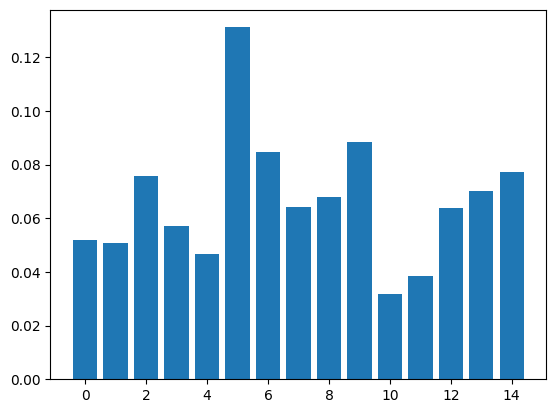

NAS:MSFT
Feature: 0, Score: 0.05499
Feature: 1, Score: 0.04640
Feature: 2, Score: 0.06748
Feature: 3, Score: 0.05084
Feature: 4, Score: 0.04493
Feature: 5, Score: 0.16959
Feature: 6, Score: 0.09486
Feature: 7, Score: 0.08460
Feature: 8, Score: 0.06790
Feature: 9, Score: 0.07294
Feature: 10, Score: 0.03004
Feature: 11, Score: 0.03044
Feature: 12, Score: 0.07273
Feature: 13, Score: 0.06537
Feature: 14, Score: 0.04690


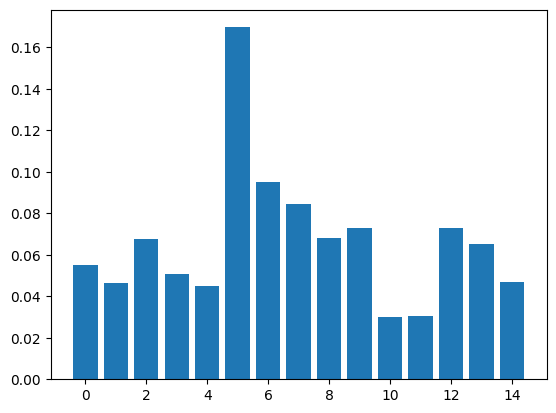

NAS:AMZN
Feature: 0, Score: 0.05750
Feature: 1, Score: 0.05837
Feature: 2, Score: 0.07439
Feature: 3, Score: 0.04963
Feature: 4, Score: 0.04523
Feature: 5, Score: 0.10224
Feature: 6, Score: 0.06828
Feature: 7, Score: 0.08629
Feature: 8, Score: 0.07122
Feature: 9, Score: 0.07197
Feature: 10, Score: 0.05226
Feature: 11, Score: 0.04448
Feature: 12, Score: 0.06324
Feature: 13, Score: 0.08009
Feature: 14, Score: 0.07479


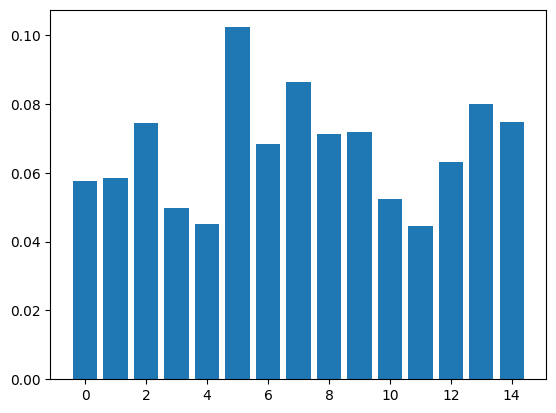

NYS:JPM
Feature: 0, Score: 0.05813
Feature: 1, Score: 0.03773
Feature: 2, Score: 0.05554
Feature: 3, Score: 0.04089
Feature: 4, Score: 0.03916
Feature: 5, Score: 0.09564
Feature: 6, Score: 0.08770
Feature: 7, Score: 0.06069
Feature: 8, Score: 0.11781
Feature: 9, Score: 0.06422
Feature: 10, Score: 0.04766
Feature: 11, Score: 0.07933
Feature: 12, Score: 0.07098
Feature: 13, Score: 0.09434
Feature: 14, Score: 0.05019


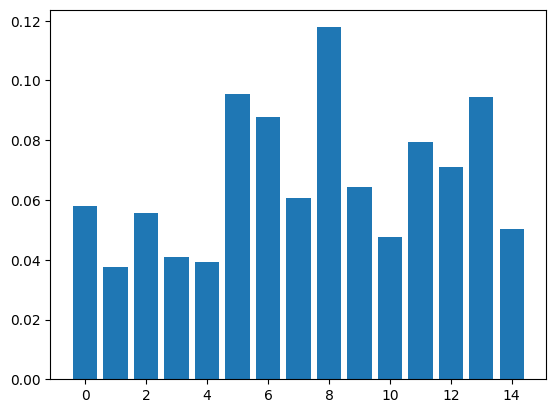

NYS:JNJ
Feature: 0, Score: 0.04117
Feature: 1, Score: 0.04459
Feature: 2, Score: 0.07191
Feature: 3, Score: 0.05791
Feature: 4, Score: 0.03600
Feature: 5, Score: 0.09588
Feature: 6, Score: 0.07145
Feature: 7, Score: 0.07207
Feature: 8, Score: 0.07298
Feature: 9, Score: 0.09564
Feature: 10, Score: 0.04864
Feature: 11, Score: 0.05319
Feature: 12, Score: 0.05729
Feature: 13, Score: 0.13678
Feature: 14, Score: 0.04449


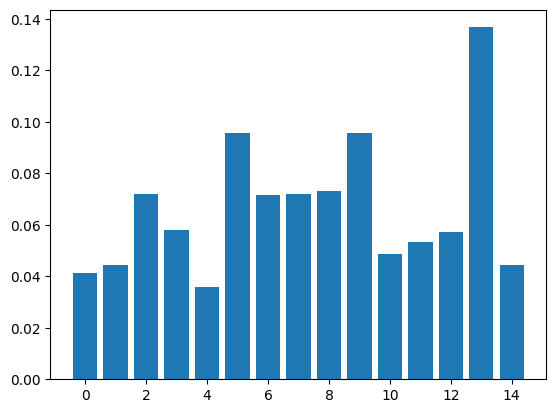

In [15]:
# Showing which features are more important in predicting:
for k in range(len(assets)):
    print(assets[k])

    importance = models[assets[k]].feature_importances_
    importance

    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))

    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

In [16]:
# loading s&p-500 stock data for testing
data = qndata.stocks.load_spx_data(min_date  ='2024-01-01', assets = assets)

| | #                                             | 34346 Elapsed Time: 0:00:00


fetched chunk 1/1 1s
Data loaded 1s


In [19]:
def predict_returns(models, data):
    """The model predicts if the price is going up or down.
       The prediction is performed for several days in order to speed up the evaluation."""
    global assets

    asset_name_all = data.coords["asset"].values
    returns = xr.zeros_like(data.sel(field="close"))

    for asset_name in assets:
        if asset_name in models:
            model = models[asset_name]
            features_all = get_features(data)
            features_cur = features_all.sel(asset=asset_name).dropna("time", how="any")
            if len(features_cur.time) < 1:
                continue
            try:
                returns.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)
            except KeyboardInterrupt as e:
                raise e
            except:
                logging.exception("model prediction failed")

    return returns

In [21]:
predicted_returns = predict_returns(models, data)

In [22]:
def predict_weights(models, data):
    """The model predicts if the price is going up or down.
       The prediction is performed for several days in order to speed up the evaluation."""
    global assets

    asset_name_all = data.coords["asset"].values
    returns = xr.zeros_like(data.sel(field="close"))

    for asset_name in assets:
        if asset_name in models:
            model = models[asset_name]
            features_all = get_features(data)
            features_cur = features_all.sel(asset=asset_name).dropna("time", how="any")
            if len(features_cur.time) < 1:
                continue
            try:
                returns.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)
            except KeyboardInterrupt as e:
                raise e
            except:
                logging.exception("model prediction failed")


    move = 0.0001
    wdata = []
    for t in returns.time:
        r= returns.sel(time=t).data
        sp = r[r > move].sum()
        sn = r[r < -move].sum()
        wt  = []
        for v in r:
            if v > move:
                wt.append(v/sp)
            elif v < -move:
                wt.append(-v/sn)
            else:
                wt.append(0.0)
        wdata.append(np.array(wt))

    weights = xr.DataArray(
            data = np.array(wdata),
            dims = returns.dims,
            coords = dict(
                asset = returns.coords['asset'],
                time = returns .coords['time'],
                field = np.array('weigths', dtype='<U7'),
            ),
            attrs = returns.attrs)

    #weights = qnout.clean(weights, data, "stocks_s&p500")
    return weights

In [23]:
weights = predict_weights(models, data)

In [24]:
for i in range(len(assets)):
    print(assets[i])

    price = data.sel(field="close")
    price_nextday = price.shift(time=-1)
    daily_return = (price_nextday - price)/price
    daily_return =  daily_return.dropna(dim ='time')
    my_targetclass = get_target_classes(data)

    asseti_df= pd.DataFrame()
    asseti_df["price"] = price.to_pandas()[assets[i]]
    asseti_df["price nextday"] = price_nextday.to_pandas()[assets[i]]
    asseti_df["daily_return"] = daily_return.to_pandas()[assets[i]]
    asseti_df["target_return"] = my_targetclass.to_pandas()[assets[i]]
    asseti_df["predicted return"] = predicted_returns.to_pandas()[assets[i]]
    asseti_df["predicted weights"] = weights.to_pandas()[assets[i]]
    display(asseti_df.tail(10))

NAS:AAPL


,price,price nextday,daily_return,target_return,predicted return,predicted weights
time,,,,,,
2025-06-17,195.64,196.58,0.004805,0.004805,0.004405,1.000000
2025-06-18,196.58,201.00,0.022484,0.022484,0.009432,0.942696
2025-06-20,201.00,201.50,0.002488,0.002488,0.007245,1.000000
2025-06-23,201.50,200.30,-0.005955,-0.005955,0.003761,1.000000
2025-06-24,200.30,201.56,0.006291,0.006291,0.010803,0.932372
2025-06-25,201.56,201.00,-0.002778,-0.002778,0.009435,0.775545
2025-06-26,201.00,201.08,0.000398,0.000398,0.004858,0.670206
2025-06-27,201.08,205.17,0.020340,0.020340,0.007006,0.738906
2025-06-30,205.17,207.82,0.012916,0.012916,0.007528,0.576867


NAS:MSFT


,price,price nextday,daily_return,target_return,predicted return,predicted weights
time,,,,,,
2025-06-17,478.04,480.24,0.004602,0.004602,-0.000798,-0.039539
2025-06-18,480.24,477.40,-0.005914,-0.005914,0.000573,0.057304
2025-06-20,477.40,486.00,0.018014,0.018014,-0.003883,-0.216223
2025-06-23,486.00,490.11,0.008457,0.008457,-0.000048,0.000000
2025-06-24,490.11,492.27,0.004407,0.004407,0.000784,0.067628
2025-06-25,492.27,497.45,0.010523,0.010523,0.002731,0.224455
2025-06-26,497.45,495.94,-0.003035,-0.003035,0.002390,0.329794
2025-06-27,495.94,497.41,0.002964,0.002964,-0.001731,-0.082358
2025-06-30,497.41,492.05,-0.010776,-0.010776,0.001969,0.150913


NAS:AMZN


,price,price nextday,daily_return,target_return,predicted return,predicted weights
time,,,,,,
2025-06-17,214.82,212.52,-0.010707,-0.010707,-0.008778,-0.435184
2025-06-18,212.52,209.69,-0.013316,-0.013316,-0.010285,-0.558700
2025-06-20,209.69,208.47,-0.005818,-0.005818,-0.009349,-0.520569
2025-06-23,208.47,212.77,0.020626,0.020626,-0.010997,-0.552222
2025-06-24,212.77,211.99,-0.003666,-0.003666,-0.008607,-0.650602
2025-06-25,211.99,217.12,0.024199,0.024199,-0.010211,-0.601849
2025-06-26,217.12,223.30,0.028464,0.028464,-0.004592,-0.279221
2025-06-27,223.30,219.39,-0.017510,-0.017510,-0.008792,-0.418278
2025-06-30,219.39,220.46,0.004877,0.004877,-0.010169,-0.478045


NYS:JPM


,price,price nextday,daily_return,target_return,predicted return,predicted weights
time,,,,,,
2025-06-17,269.52,273.96,0.016474,0.016474,-0.005754,-0.285280
2025-06-18,273.96,275.00,0.003796,0.003796,-0.006662,-0.361880
2025-06-20,275.00,278.27,0.011891,0.011891,-0.002719,-0.151420
2025-06-23,278.27,281.26,0.010745,0.010745,-0.004736,-0.237845
2025-06-24,281.26,284.06,0.009955,0.009955,-0.003757,-0.284026
2025-06-25,284.06,288.75,0.016511,0.016511,-0.006755,-0.398151
2025-06-26,288.75,287.11,-0.005680,-0.005680,-0.011183,-0.679988
2025-06-27,287.11,289.91,0.009752,0.009752,-0.010496,-0.499364
2025-06-30,289.91,290.41,0.001725,0.001725,-0.011103,-0.521955


NYS:JNJ


,price,price nextday,daily_return,target_return,predicted return,predicted weights
time,,,,,,
2025-06-17,152.38,150.73,-0.010828,-0.010828,-0.004841,-0.239997
2025-06-18,150.73,149.79,-0.006236,-0.006236,-0.001462,-0.079420
2025-06-20,149.79,151.32,0.010214,0.010214,-0.002008,-0.111788
2025-06-23,151.32,152.19,0.005749,0.005749,-0.004181,-0.209934
2025-06-24,152.19,152.28,0.000591,0.000591,-0.000865,-0.065372
2025-06-25,152.28,152.01,-0.001773,-0.001773,-0.000086,0.000000
2025-06-26,152.01,152.41,0.002631,0.002631,-0.000671,-0.040791
2025-06-27,152.41,152.75,0.002231,0.002231,0.002476,0.261094
2025-06-30,152.75,155.92,0.020753,0.020753,0.003552,0.272220


In [25]:
def get_sharpe(data, weights):
    """Calculates the Sharpe ratio"""
    rr = qnstats.calc_relative_return(data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(data, weights)
sharpe

np.float64(-1.245388106598489)

In [26]:
import qnt.graph as qngraph

statistics = qnstats.calc_stat(data, weights)

display(statistics.to_pandas().tail())

performance = statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())

# check for correlations with existing strategies:
qnstats.print_correlation(weights,data)

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2025-06-25,0.766829,0.003486,0.132341,-0.333637,-0.339545,-1.237807,-0.163812,-5.551115e-17,5.0,0.422465,3.863914
2025-06-26,0.758483,-0.010885,0.132427,-0.340890,-0.340890,-1.280263,-0.169541,0.000000e+00,5.0,0.422067,3.871342
2025-06-27,0.753766,-0.006218,0.132326,-0.344989,-0.344989,-1.304309,-0.172594,2.775558e-17,5.0,0.422112,3.893333
2025-06-30,0.759805,0.008012,0.132341,-0.339741,-0.344989,-1.267534,-0.167747,1.110223e-16,5.0,0.422464,3.888961
2025-07-01,0.763434,0.004776,0.132240,-0.336587,-0.344989,-1.245388,-0.164690,2.775558e-17,5.0,0.422021,3.937133


time,2025-07-01
field,
sharpe_ratio,-1.245388


NOTICE: The environment variable ENGINE_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/referee/submission/forCorrelation'
NOTICE: The environment variable STATAN_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/statan/correlation'
NOTICE: The environment variable PARTICIPANT_ID was not specified. The default value is '0'



Ok. This strategy does not correlate with other strategies.


Let us now use the Quantiacs **backtester** for avoiding **forward looking**.

The backtester performs some transformations: it trains the model on one slice of data (using only data from the past) and predicts the weights for the following slice on a rolling basis:

In [ ]:
# Calculate weights using the backtester:
weights = qnbt.backtest_ml(
    train                         = train_models,
    predict                       = predict_weights,
    train_period                  = 5 *365,  # the data length for training in calendar days
    retrain_interval              = 365,  # how often we have to retrain models (calendar days)
    retrain_interval_after_submit = 1,        # how often retrain models after submission during evaluation (calendar days)
    predict_each_day              = False,    # Is it necessary to call prediction for every day during backtesting?
                                              # Set it to True if you suspect that get_features is looking forward.
    competition_type              = "stocks_s&p500",  # competition type
    lookback_period               = 365,                 # how many calendar days are needed by the predict function to generate the output
    start_date                    = "2006-01-01",        # backtest start date
    analyze                       = True,
    build_plots                   = True  # do you need the chart?
)

Run the last iteration...


| | #                                             | 24833 Elapsed Time: 0:00:00
| |           #                                 | 3677748 Elapsed Time: 0:00:01


fetched chunk 1/5 4s


| |           #                                 | 3601655 Elapsed Time: 0:00:01


fetched chunk 2/5 7s


| |          #                                  | 3487194 Elapsed Time: 0:00:01


fetched chunk 3/5 11s


| |           #                                 | 3499263 Elapsed Time: 0:00:01


fetched chunk 4/5 15s


| |          #                                  | 3416798 Elapsed Time: 0:00:01


fetched chunk 5/5 19s
Data loaded 20s
NAS:AAPL RandomForestRegressor(random_state=42)
    r2 0.8521426919162813
    mean_absolute_error 0.00504736436602342
    explained_variance 0.8521738649306555
NAS:MSFT RandomForestRegressor(random_state=42)
    r2 0.8537688151721553
    mean_absolute_error 0.004687067390810983
    explained_variance 0.8537750458275556
NAS:AMZN RandomForestRegressor(random_state=42)
    r2 0.841306993571155
    mean_absolute_error 0.0062435391270529396
    explained_variance 0.8413137770587181
NYS:JPM RandomForestRegressor(random_state=42)
    r2 0.8466828530055832
    mean_absolute_error 0.00443866866872614
    explained_variance 0.8467084592092612
NYS:JNJ RandomForestRegressor(random_state=42)
    r2 0.8553642937105173
    mean_absolute_error 0.002990186090431537
    explained_variance 0.8553741511798686


| |      #                                       | 583883 Elapsed Time: 0:00:00


fetched chunk 1/1 10s
Data loaded 10s
Output cleaning...
Fix unique timestamps
Forward filling missing prices...
Check liquidity...
Ok.
Check for missed dates...
Ok.
Normalize and cut big positions for index strategies (nasdaq100, s&p500)...
Final normalization...
Output cleaning complete.


NOTICE: The environment variable OUTPUT_PATH was not specified. The default value is 'fractions.nc.gz'


Write output: fractions.nc.gz


NOTICE: The environment variable OUT_STATE_PATH was not specified. The default value is 'state.out.pickle.gz'


State saved.
---
Run First Iteration...


| | #                                             | 24833 Elapsed Time: 0:00:00
| |         #                                   | 2415354 Elapsed Time: 0:00:00


fetched chunk 1/5 3s


| |         #                                   | 2481972 Elapsed Time: 0:00:00


fetched chunk 2/5 7s


| |          #                                  | 3373015 Elapsed Time: 0:00:01


fetched chunk 3/5 10s


| |          #                                  | 3388392 Elapsed Time: 0:00:01


fetched chunk 4/5 14s


| |          #                                  | 3370062 Elapsed Time: 0:00:01


fetched chunk 5/5 18s
Data loaded 19s
NAS:AAPL RandomForestRegressor(random_state=42)
    r2 0.85066858859894
    mean_absolute_error 0.007967037687953761
    explained_variance 0.8506723967981152
NAS:MSFT RandomForestRegressor(random_state=42)
    r2 0.8504189078828648
    mean_absolute_error 0.005089240742986243
    explained_variance 0.8504213039789519
NAS:AMZN RandomForestRegressor(random_state=42)
    r2 0.8534382893715508
    mean_absolute_error 0.00992342666824877
    explained_variance 0.8534403072675771
NYS:JPM RandomForestRegressor(random_state=42)
    r2 0.8395650657026761
    mean_absolute_error 0.005505548363543859
    explained_variance 0.8395655352693162
NYS:JNJ RandomForestRegressor(random_state=42)
    r2 0.8590735362058922
    mean_absolute_error 0.0035595838663447558
    explained_variance 0.8590755431407627
---
Run all iterations...
Load data...


| | #                                             | 24833 Elapsed Time: 0:00:00
| |          #                                  | 2793470 Elapsed Time: 0:00:01


fetched chunk 1/26 2s


| |         #                                   | 2909301 Elapsed Time: 0:00:00


fetched chunk 2/26 5s


| |          #                                  | 2793835 Elapsed Time: 0:00:01


fetched chunk 3/26 7s


| |          #                                  | 2905255 Elapsed Time: 0:00:01


fetched chunk 4/26 10s


| |         #                                   | 2932512 Elapsed Time: 0:00:00


fetched chunk 5/26 12s


| |         #                                   | 2787511 Elapsed Time: 0:00:00


fetched chunk 6/26 14s


| |         #                                   | 2240174 Elapsed Time: 0:00:00


fetched chunk 7/26 16s


| |         #                                   | 2940940 Elapsed Time: 0:00:00


fetched chunk 8/26 18s


| |         #                                   | 2808892 Elapsed Time: 0:00:00


fetched chunk 9/26 21s


| |          #                                  | 3344873 Elapsed Time: 0:00:01


fetched chunk 10/26 23s


| |          #                                  | 3205738 Elapsed Time: 0:00:01


fetched chunk 11/26 26s


| |          #                                  | 3230780 Elapsed Time: 0:00:01


fetched chunk 12/26 28s


| |          #                                  | 3349300 Elapsed Time: 0:00:01


fetched chunk 13/26 31s


| |         #                                   | 3222211 Elapsed Time: 0:00:00


fetched chunk 14/26 33s


| |           #                                 | 3289069 Elapsed Time: 0:00:01


fetched chunk 15/26 36s


| |           #                                 | 3314066 Elapsed Time: 0:00:01


fetched chunk 16/26 38s


| |         #                                   | 3386284 Elapsed Time: 0:00:00


fetched chunk 17/26 40s


| |         #                                   | 3322299 Elapsed Time: 0:00:00


fetched chunk 18/26 43s


| |         #                                   | 3336033 Elapsed Time: 0:00:00


fetched chunk 19/26 45s


| |           #                                 | 3213950 Elapsed Time: 0:00:01


fetched chunk 20/26 48s


| |         #                                   | 3322206 Elapsed Time: 0:00:00


fetched chunk 21/26 50s


| |           #                                 | 3462677 Elapsed Time: 0:00:01


fetched chunk 22/26 53s


| |           #                                 | 3590628 Elapsed Time: 0:00:01


fetched chunk 23/26 55s


| |          #                                  | 3576421 Elapsed Time: 0:00:01


fetched chunk 24/26 58s


| |          #                                  | 3179205 Elapsed Time: 0:00:01


fetched chunk 25/26 60s


| |     #                                        | 704331 Elapsed Time: 0:00:00


fetched chunk 26/26 61s
Data loaded 64s


| | #                                             | 24833 Elapsed Time: 0:00:00
| |          #                                  | 3075763 Elapsed Time: 0:00:01


fetched chunk 1/20 2s


| |          #                                  | 3168947 Elapsed Time: 0:00:01


fetched chunk 2/20 5s


| |           #                                 | 3080928 Elapsed Time: 0:00:01


fetched chunk 3/20 8s


| |         #                                   | 3230944 Elapsed Time: 0:00:00


fetched chunk 4/20 10s


| |          #                                  | 2807743 Elapsed Time: 0:00:01


fetched chunk 5/20 12s


| |          #                                  | 3095875 Elapsed Time: 0:00:01


fetched chunk 6/20 15s


| |         #                                   | 3058303 Elapsed Time: 0:00:00


fetched chunk 7/20 17s


| |          #                                  | 3426434 Elapsed Time: 0:00:01


fetched chunk 8/20 20s


| |          #                                  | 3365437 Elapsed Time: 0:00:01


fetched chunk 9/20 23s


| |          #                                  | 3356489 Elapsed Time: 0:00:01


fetched chunk 10/20 25s


| |          #                                  | 3313417 Elapsed Time: 0:00:01


fetched chunk 11/20 28s


| |       #                                      | 700416 Elapsed Time: 0:00:00